In [1]:
import numpy as np
import sys,os
import matplotlib.pyplot as plt
from scipy.stats import multivariate_t as mvt, norm 
import sklearn
from sklearn.covariance import GraphicalLasso
import scipy
from sklearn.metrics import zero_one_loss
from sklearn.metrics.pairwise import pairwise_kernels
import time
import tqdm
import networkx as nx
import pandas as pd
import matplotlib.pylab as pylab
params = {'legend.fontsize': 25,
         'axes.labelsize': 25,
         'axes.titlesize':25,
         'xtick.labelsize':25,
         'ytick.labelsize':'x-large',
          'axes.titlesize' : 'x-large'}
pylab.rcParams.update(params)
sys.path.insert(0, 'C:/Users/User/Code/DyGraph/src')
sys.path.insert(0, 'C:/Users/User/Code/DyGraph')

import DyGraph as dg
import port_measures as pm

# Test Code

In [3]:
from sklearn.datasets import make_sparse_spd_matrix
d = 5
A = make_sparse_spd_matrix(d, alpha=0.6)
X = mvt.rvs(loc = np.zeros(d),df = 4, shape = np.linalg.inv(A), size=110)

Error 2.26E-1:   1%|          | 12/1000 [00:00<00:02, 352.86it/s]

Error 9.74E-6:  28%|██▊       | 276/1000 [00:00<00:01, 365.95it/s]


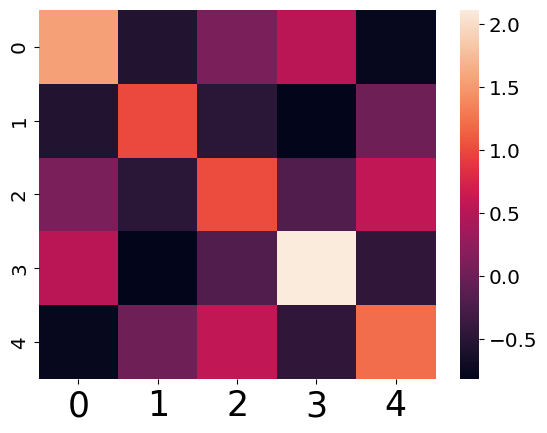

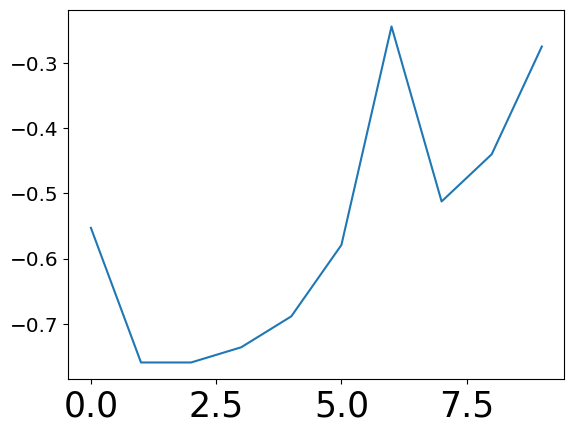

In [4]:
# I assume that you have the data in a pandas data frame, which I call data. I am also assuming it has 99 rows (months) and 100 columns (agencies)
# The procedure is as follows:
from sklearn.preprocessing import StandardScaler 
import DyGraph as dg
#X = np.array(data)  # Create an numpy array (not strictly necessary)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Probably better to scale the data to unit variance and zero mean.

# Declare hyperparameters

obs_per_graph = 11  # This means the first 11 observations are used to create graph 1, next 11 observations are used to create graph 2 etc, giving total of 9 graphs.
tol = 1e-5  # We want to reach an error below this tolerance
max_iter = 1000  # number of tries reach an error of tolerance, 1000 should be sufficient, if not try to increase this number
alpha = 0.02  # sparsity regularization, we have to play with this to give best fit.
kappa = 0.1  # temporal regularization, how similar adjacent graphs should be. A high number not detect any changes but a low value will detect too many changes (noise)
lik_type = 'gaussian'  # start with a gaussian likelihood, can also be set to t, group-t and skew-group-t, but note group-t and skew-group-t are slow and will need additional paramters.
temporal_penalty = 'element-wise'  # temporal penalty, can also be ridge, block-wise-reconstruction, global-reconstruction, perturbed-node


# Fit
dg_opt = dg.dygl_inner_em(X,  obs_per_graph = obs_per_graph, max_iter = max_iter, lamda = alpha,  kappa = kappa, tol = tol, lik_type='gaussian')
dg_opt.fit(temporal_penalty = temporal_penalty)

# Get graphs
dg_opt.theta

len(dg_opt.theta)  # should be 9 as we estimated 9 graphs, see obs_per_graph parameter

# can plot heatmaps of estimated graphs
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
sns.heatmap(dg_opt.theta[0], ax = ax)  # heatmap of graph 1 

fig, ax = plt.subplots(1,1)
ax.plot(dg_opt.theta[:,0,1])

array([0.1888756])

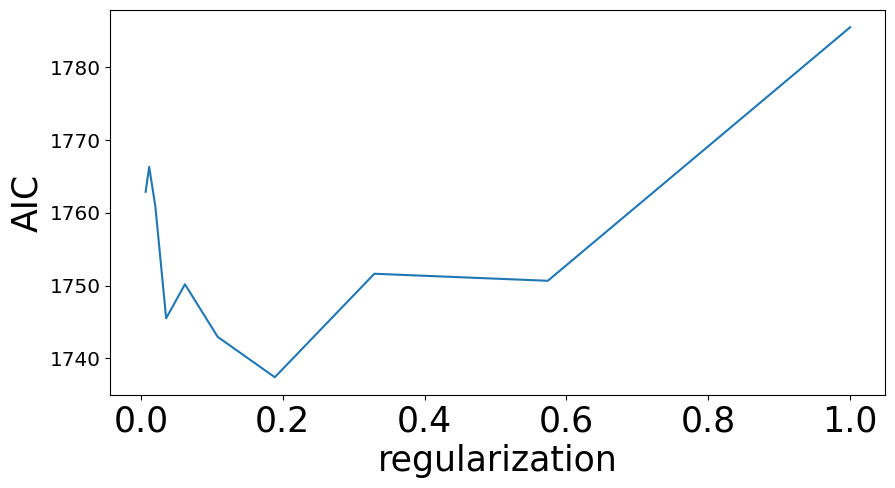

In [5]:
# Find best alpha, using code from before
# How to find best kappa remains an open problem, but one could try to set it to a value such that known changepoints are captured.

from scipy.stats import multivariate_normal, multivariate_t

# Define a function to calcualte the log-likelihoods for each time points
# Returns a list of log likelihoods for each graph
def log_lik(thetas, nus, obs_per_graph, X, liktype = 'gaussian') -> list:
    """
    theta: thetas attribute from dygraph
    nus: nu attribute from dygraph. Degrees of freedoms for each graph
    obs_per_graph: number of observations for each graph
    X: the data
    liktype: likelihood type, gaussian or r
    """

    likelihoods = []
    w = obs_per_graph
    d = thetas[-1].shape[0]

    for j in range(len(thetas)):

        cov = np.linalg.inv(thetas[j])

        if liktype == "gaussian":
            likelihoods.append(np.sum(multivariate_normal.logpdf(X[j*w:(j+1)*w], mean=np.zeros(d), cov=cov, allow_singular=True)))
        elif liktype == "t":
            likelihoods.append(np.sum(multivariate_t.logpdf(X[j*w:(j+1)*w], loc = np.zeros(d), shape=cov, df = nus[j])))

    return likelihoods


# Define a function to calculate the number of parameters
# Returns a list of parameter counts for each graph
def find_nr_params(thetas, lik_type = 'gaussian', edge_tol = 1e-2):
    """
    thetas: theta attribute from dygraph
    liktype: likelihood type, gaussian or r
    edge_tol: As the glasso may not return exactly zeros, we define a tolerance to set edges to precisely zero.
    """

    
    
    nr_params_tmp = []
    for iii in range(len(thetas)):
        theta_t = thetas[iii].copy()
        theta_t[np.abs(theta_t)<edge_tol] = 0
        if lik_type == 't':
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0) + 1.0)
        elif lik_type == "gaussian":
            nr_params_tmp.append(np.sum(theta_t[np.triu_indices(theta_t.shape[0],1)] != 0))

    return np.array(nr_params_tmp)


# Now loop over possible alphas to find best AIC

AIC = []

alphas = np.exp(-np.linspace(5,0,10))  # For sparser grid change 10 to 100 (or some other larger number)
for i in range(len(alphas)):

    dg_opt_tmp = dg.dygl_inner_em(X,  obs_per_graph = obs_per_graph, max_iter = max_iter, lamda = float(alphas[i]),  kappa = kappa, tol = tol, lik_type='gaussian')
    dg_opt_tmp.fit(temporal_penalty = temporal_penalty, verbose=False)

    likelihoods = log_lik(dg_opt_tmp.theta, dg_opt_tmp.nu, obs_per_graph, X, liktype = 'gaussian')
    nr_params = find_nr_params(dg_opt_tmp.theta)
    AIC.append(2*np.sum(nr_params)-2*np.sum(likelihoods))  # note likelihoods and nr_params is a list so we sum the values


# Plot
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.plot(alphas, AIC)
ax.set_ylabel("AIC")
ax.set_xlabel("regularization")


# The optimal regularization is the one which gives the lowest AIC:
alphas[np.array(AIC) == np.min(AIC)]



# Aflac Code Log

- Agencies in Tokyo and Kanagawa
- The 100 agencies with the most APs as of March 2018, which is exactly in the middle of the time series